# Automatic H&E alignment


First make sure you have installed spacemake as specified [here](https://spacemake.readthedocs.io/en/latest/install.html#installation).

Second, we need to download the pre-processed spacemake data for testing.

To download the data we do:

In [1]:
datasets = {
    'visium_adata.h5ad.gz' : 'visium/adata.h5ad.gz',
    'visium_adata_raw.h5ad.gz' : 'visium/adata_raw.h5ad.gz',
    'visium_he.tif' : 'visium/V1_Adult_Mouse_Brain_image_small.tif',
    'seq_scope_adata.h5ad.gz' : 'seq_scope/adata.h5ad.gz',
    'seq_scope_adata_raw.h5ad.gz' : 'seq_scope/adata_raw.h5ad.gz',
    'seq_scope_he.jpg' : 'seq_scope/wt_4X_1.jpg'
}

# download the data
for out_file, source in datasets.items():
    !wget -nv -O {out_file} http://bimsbstatic.mdc-berlin.de/rajewsky/spacemake-test-data/{source}

2022-03-24 18:51:25 URL:https://bimsbstatic.mdc-berlin.de/rajewsky/spacemake-test-data/visium/adata.h5ad.gz [149587898/149587898] -> "visium_adata.h5ad.gz" [1]
2022-03-24 18:51:26 URL:https://bimsbstatic.mdc-berlin.de/rajewsky/spacemake-test-data/visium/adata_raw.h5ad.gz [32210654/32210654] -> "visium_adata_raw.h5ad.gz" [1]
2022-03-24 18:51:26 URL:https://bimsbstatic.mdc-berlin.de/rajewsky/spacemake-test-data/visium/V1_Adult_Mouse_Brain_image_small.tif [3983408/3983408] -> "visium_he.tif" [1]
2022-03-24 18:51:27 URL:https://bimsbstatic.mdc-berlin.de/rajewsky/spacemake-test-data/seq_scope/adata.h5ad.gz [24100537/24100537] -> "seq_scope_adata.h5ad.gz" [1]
2022-03-24 18:51:27 URL:https://bimsbstatic.mdc-berlin.de/rajewsky/spacemake-test-data/seq_scope/adata_raw.h5ad.gz [24407276/24407276] -> "seq_scope_adata_raw.h5ad.gz" [1]
2022-03-24 18:51:28 URL:https://bimsbstatic.mdc-berlin.de/rajewsky/spacemake-test-data/seq_scope/wt_4X_1.jpg [3599455/3599455] -> "seq_scope_he.jpg" [1]


Then we uncompress the datafiles, as scanpy can't load compressed data:

In [2]:
!find . -type f -wholename '*.h5ad.gz' -exec unpigz {} \;

After we have downloaded the data, and uncompressed the objects, we load scanpy and set some default parameters and colors.

In [3]:
import scanpy as sc
import cv2

root_dir = 'spacemake-test-data'

# we set the figure to have higher dpi
sc.set_figure_params(dpi=300)


cluster_clrs = ["#0000FF","#FF0000","#00FF00","#000033","#FF00B6","#005300","#FFD300",
"#009FFF","#9A4D42","#00FFBE","#783FC1","#1F9698","#FFACFD","#B1CC71",
"#F1085C","#FE8F42","#DD00FF","#201A01","#720055","#766C95","#02AD24",
"#C8FF00","#886C00","#FFB79F","#858567","#A10300","#14F9FF","#00479E",
"#DC5E93","#93D4FF","#004CFF","#F2F318"]

cluster_clrs = {str(i): cluster_clrs[i] for i in range(len(cluster_clrs))}

## Align H&E with Visium data

This Visium dataset shown here is an adult mouse brain coronal section dataset downloaded from here https://www.10xgenomics.com/resources/datasets, processed with spacemake using the visium run mode as specified [here](https://spacemake.readthedocs.io/en/latest/config.html#provided-run-mode-s)

First we load the processed and filtered visium data:

In [4]:
adata_visium = sc.read('visium_adata.h5ad')

Then, we can align the H&E image with our data. To do this we use the [spacemake.spatial.he_integration.align_he_spot_img()](https://spacemake.readthedocs.io/en/latest/api/api.html#spacemake.spatial.he_integration.align_he_spot_img) function from spacemake. 


In [5]:
from spacemake.spatial.he_integration import align_he_spot_img

he, aligned_he = align_he_spot_img(adata_visium,
                                   'visium_he.tif')

cv2.imwrite('aligned_he_visium.png', he)

True

After we aligned the data, we can attach the result image to the original data which then we can use for plotting. For this, we use the [spacemake.spatial.he_integration.attach_he_adata()](https://spacemake.readthedocs.io/en/latest/api/api.html#spacemake.spatial.he_integration.attach_he_adata) function.

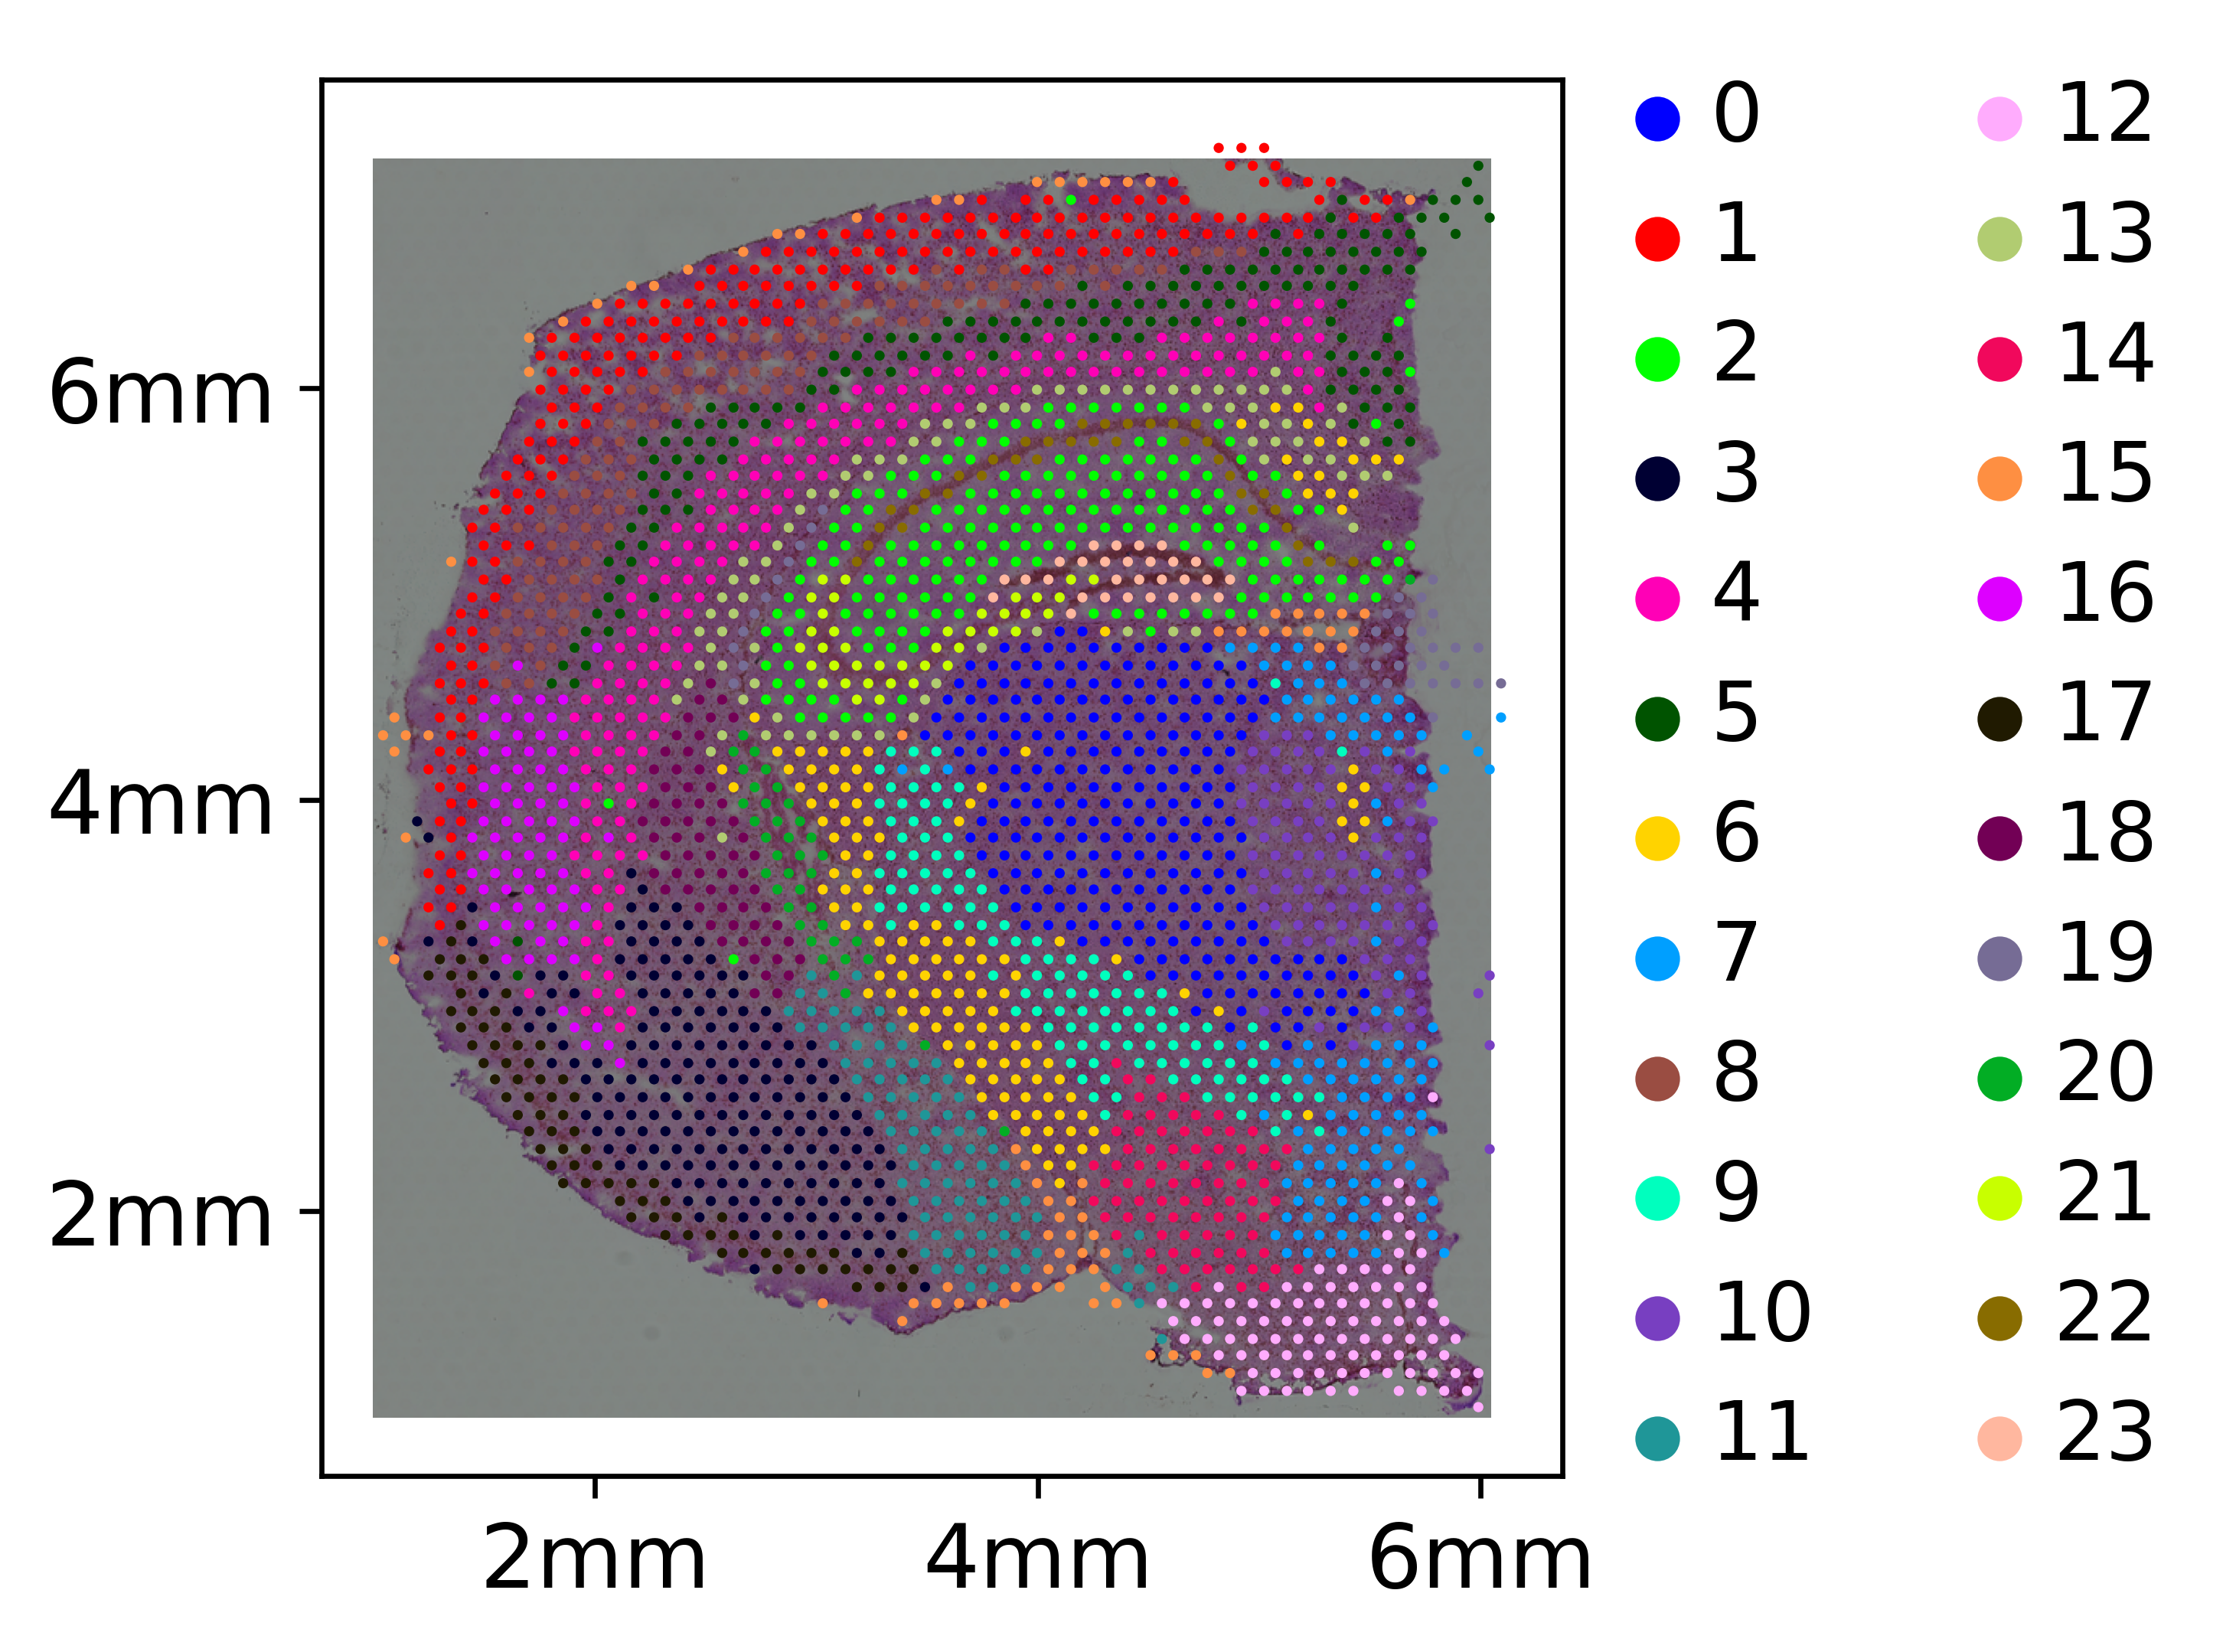

In [6]:
from spacemake.spatial.he_integration import attach_he_adata

adata_visium_attached = attach_he_adata(adata_visium.copy(), aligned_he)

plt = sc.pl.spatial(adata_visium_attached,
                    color='leiden_1.2',
                    palette=cluster_clrs,
                    return_fig=True,
                    show=False,
                    title='')

plt[0].invert_yaxis()
plt[0].figure
plt[0].set_xlabel('')
plt[0].set_ylabel('')
ticks = [x * 19.5 for x in range(1, 7, 2)]
ticks_labels = ['2mm', '4mm', '6mm']

ticks_x = [x * 7 for x in ticks]
ticks_y = [x * 6.5 for x in ticks]
plt[0].set_xticks(ticks_x)
plt[0].set_xticklabels(ticks_labels)
plt[0].set_yticks(ticks_y)
plt[0].set_yticklabels(ticks_labels)
plt[0].grid(False)

## Align H&E with Seq-scope data

For the [Seq-scope dataset](https://www.sciencedirect.com/science/article/abs/pii/S0092867421006279) shown here we used tile nr. 2107. The data was processed with spacemake using the seq_scope run mode as specified [here](https://spacemake.readthedocs.io/en/latest/index.html). In this run mode the data will be meshed into a hexagonal meshgrid of 10 micron side equal hexagons.

For samples such as Seq-scope, where the spatial-unit (spot) diameter is smaller than 10 microns, it is better to first align the H&E image with the raw data, and then using this align attach the aligned H&E to the processed data. Therefore, we first load the raw (not meshed) Seq-scope dataset:

In [7]:
adata_seq_scope_raw = sc.read('seq_scope_adata_raw.h5ad')

To align the H&E with the raw data we use [spacemake.spatial.he_integration.align_he_aggregated_img()](https://spacemake.readthedocs.io/en/latest/api/api.html#spacemake.spatial.he_integration.align_he_aggregated_img). Rather than working with spots, this function will first generate an aggregated image from the spatial expression data, and align it with our H&E.

In [9]:
from spacemake.spatial.he_integration import align_he_aggregated_img

he, aligned_he = align_he_aggregated_img(adata_seq_scope_raw,
                                'seq_scope_he.jpg', bw_threshold=200, box_size=0.6)

cv2.imwrite('aligned_he_seq_scope.png', he)

True

After we aligned the H&E image using the raw data adata, we load the processed Seq-scope data:

In [10]:
adata_seq_scope = sc.read('seq_scope_adata.h5ad')

Then we attach it with the same function [spacemake.spatial.he_integration.attach_he_adata()](https://spacemake.readthedocs.io/en/latest/api/api.html#spacemake.spatial.he_integration.attach_he_adata) as for visium. However here we have to specify that the raw dataset was aligned, and also the aligned H&E should not be pushed by one spot diameter.

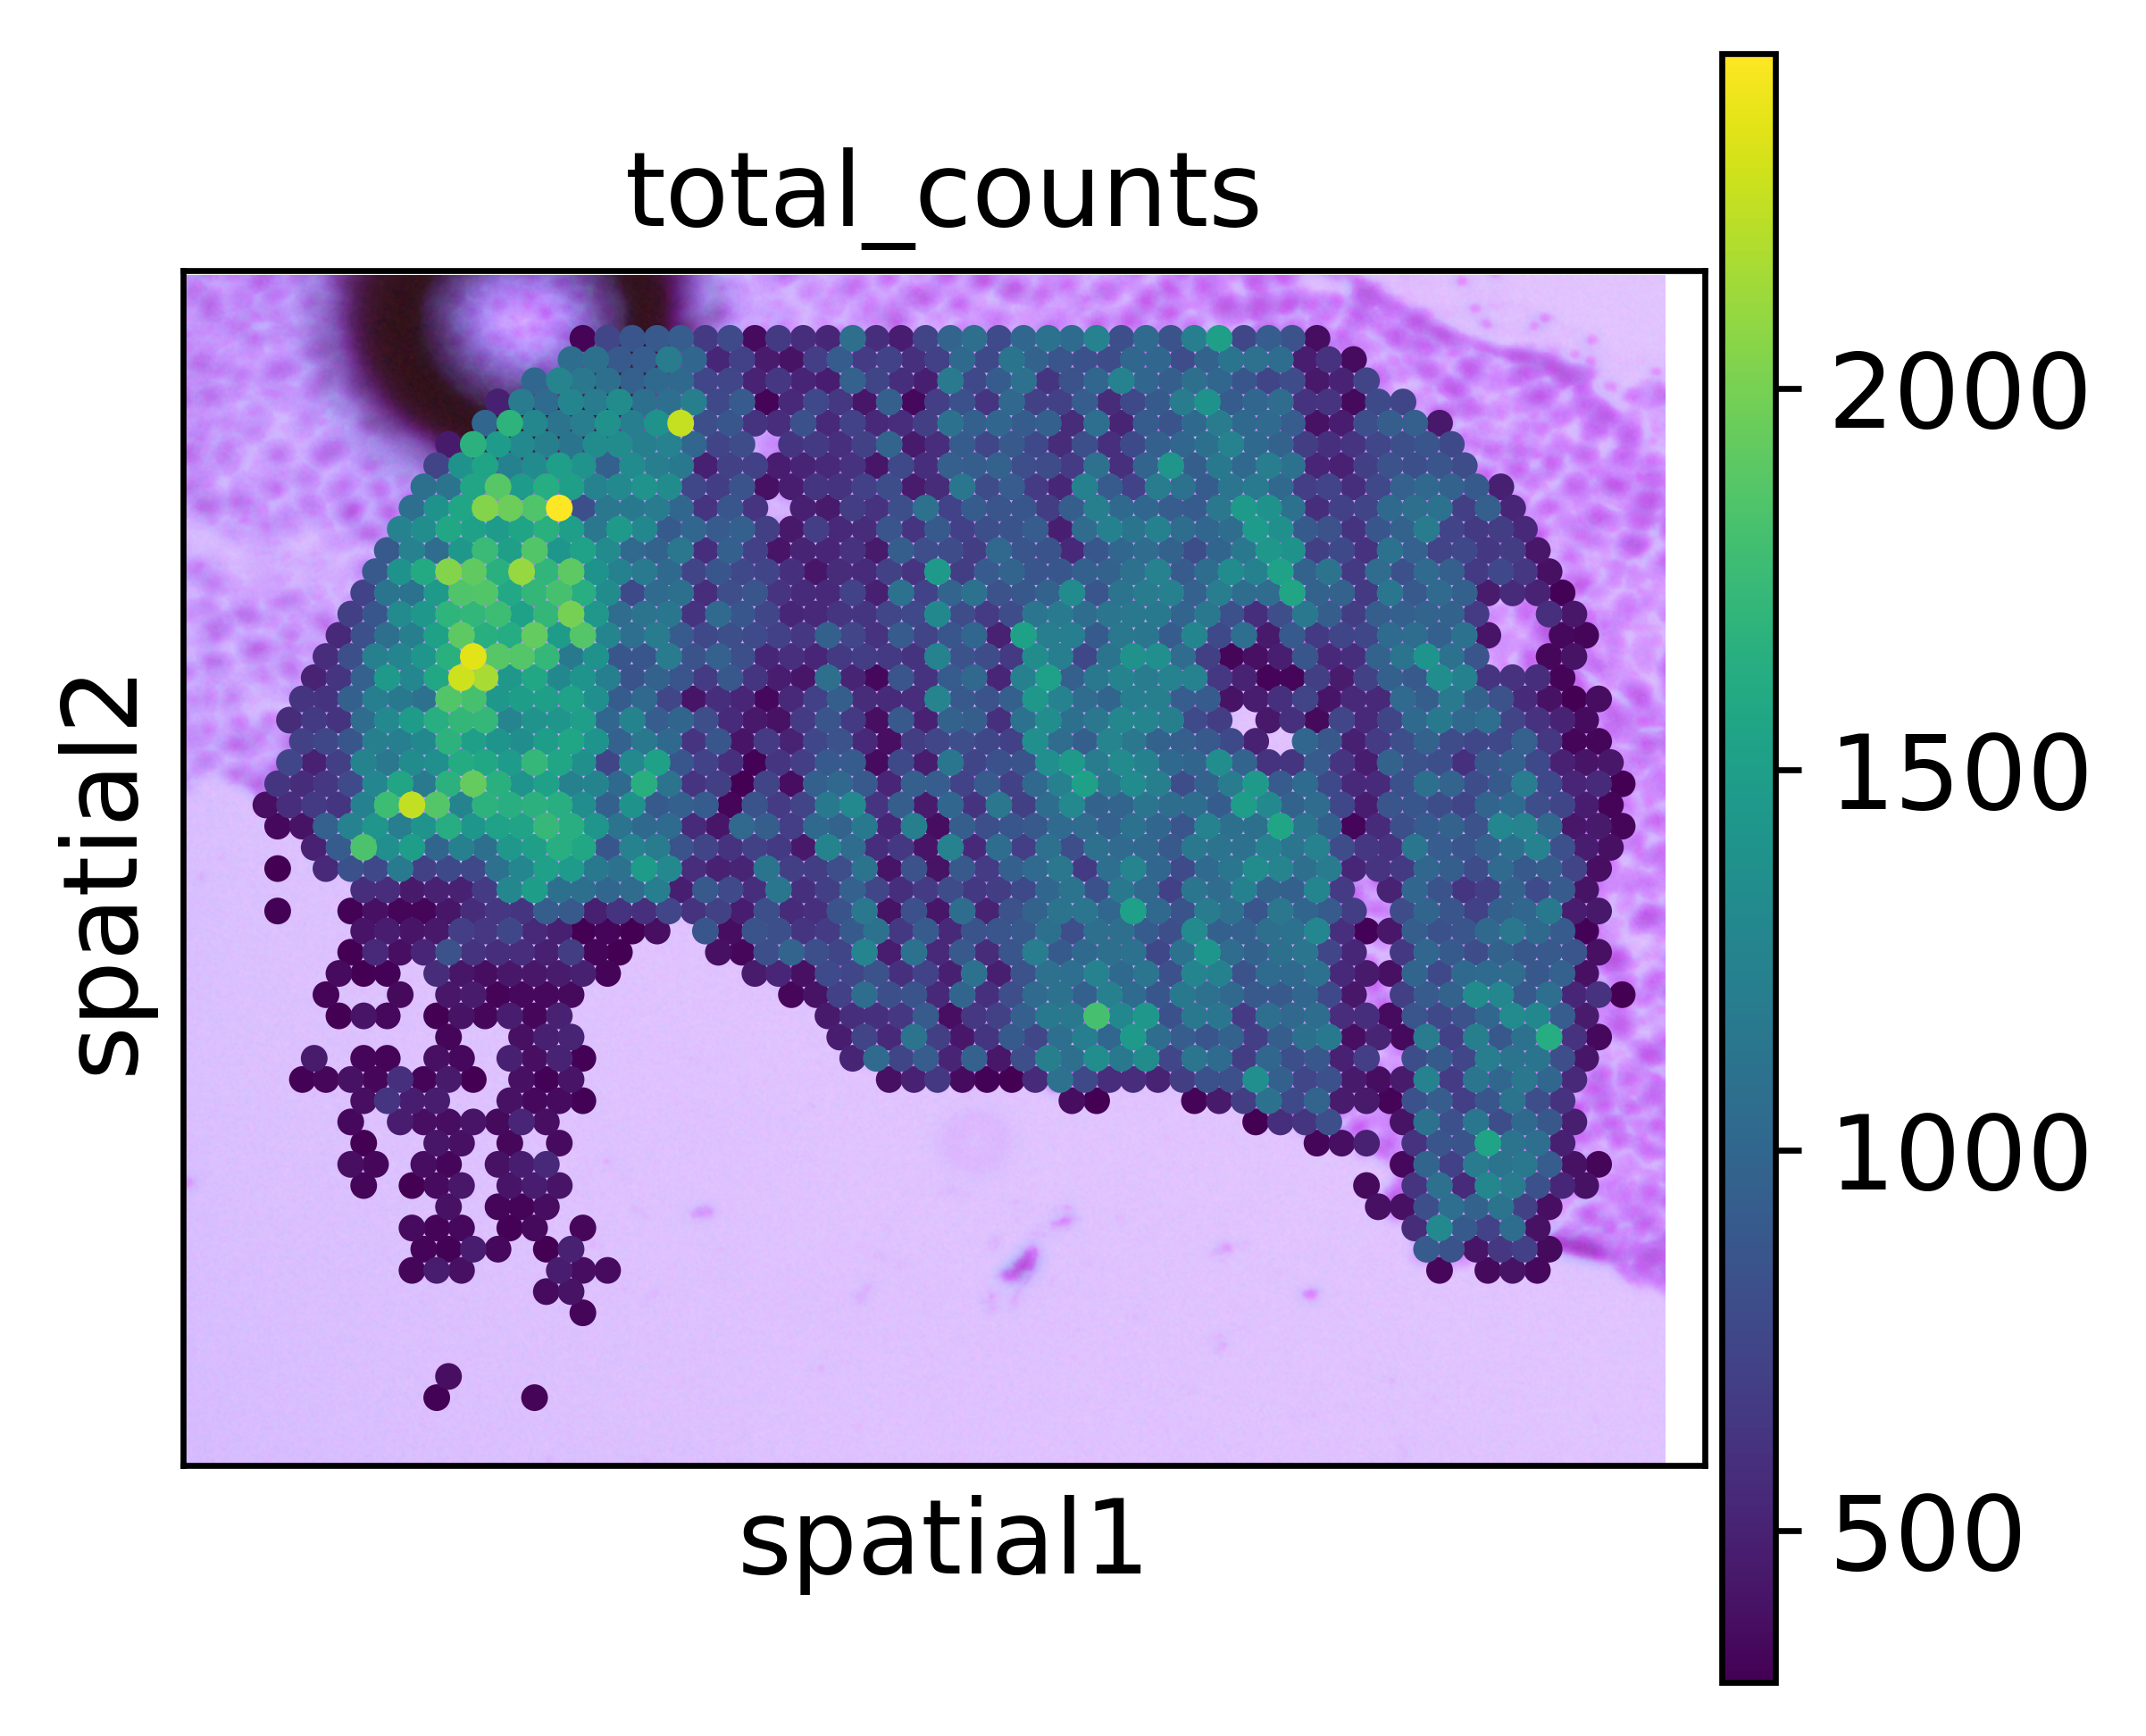

In [11]:
adata_seq_scope_attached = attach_he_adata(adata_seq_scope.copy(), aligned_he,
                         push_by_spot_diameter=False, raw_aligned=True)

sc.pl.spatial(adata_seq_scope_attached, color='total_counts')

To see better how the align looks like, we plot only spots with at least 700 UMIs.

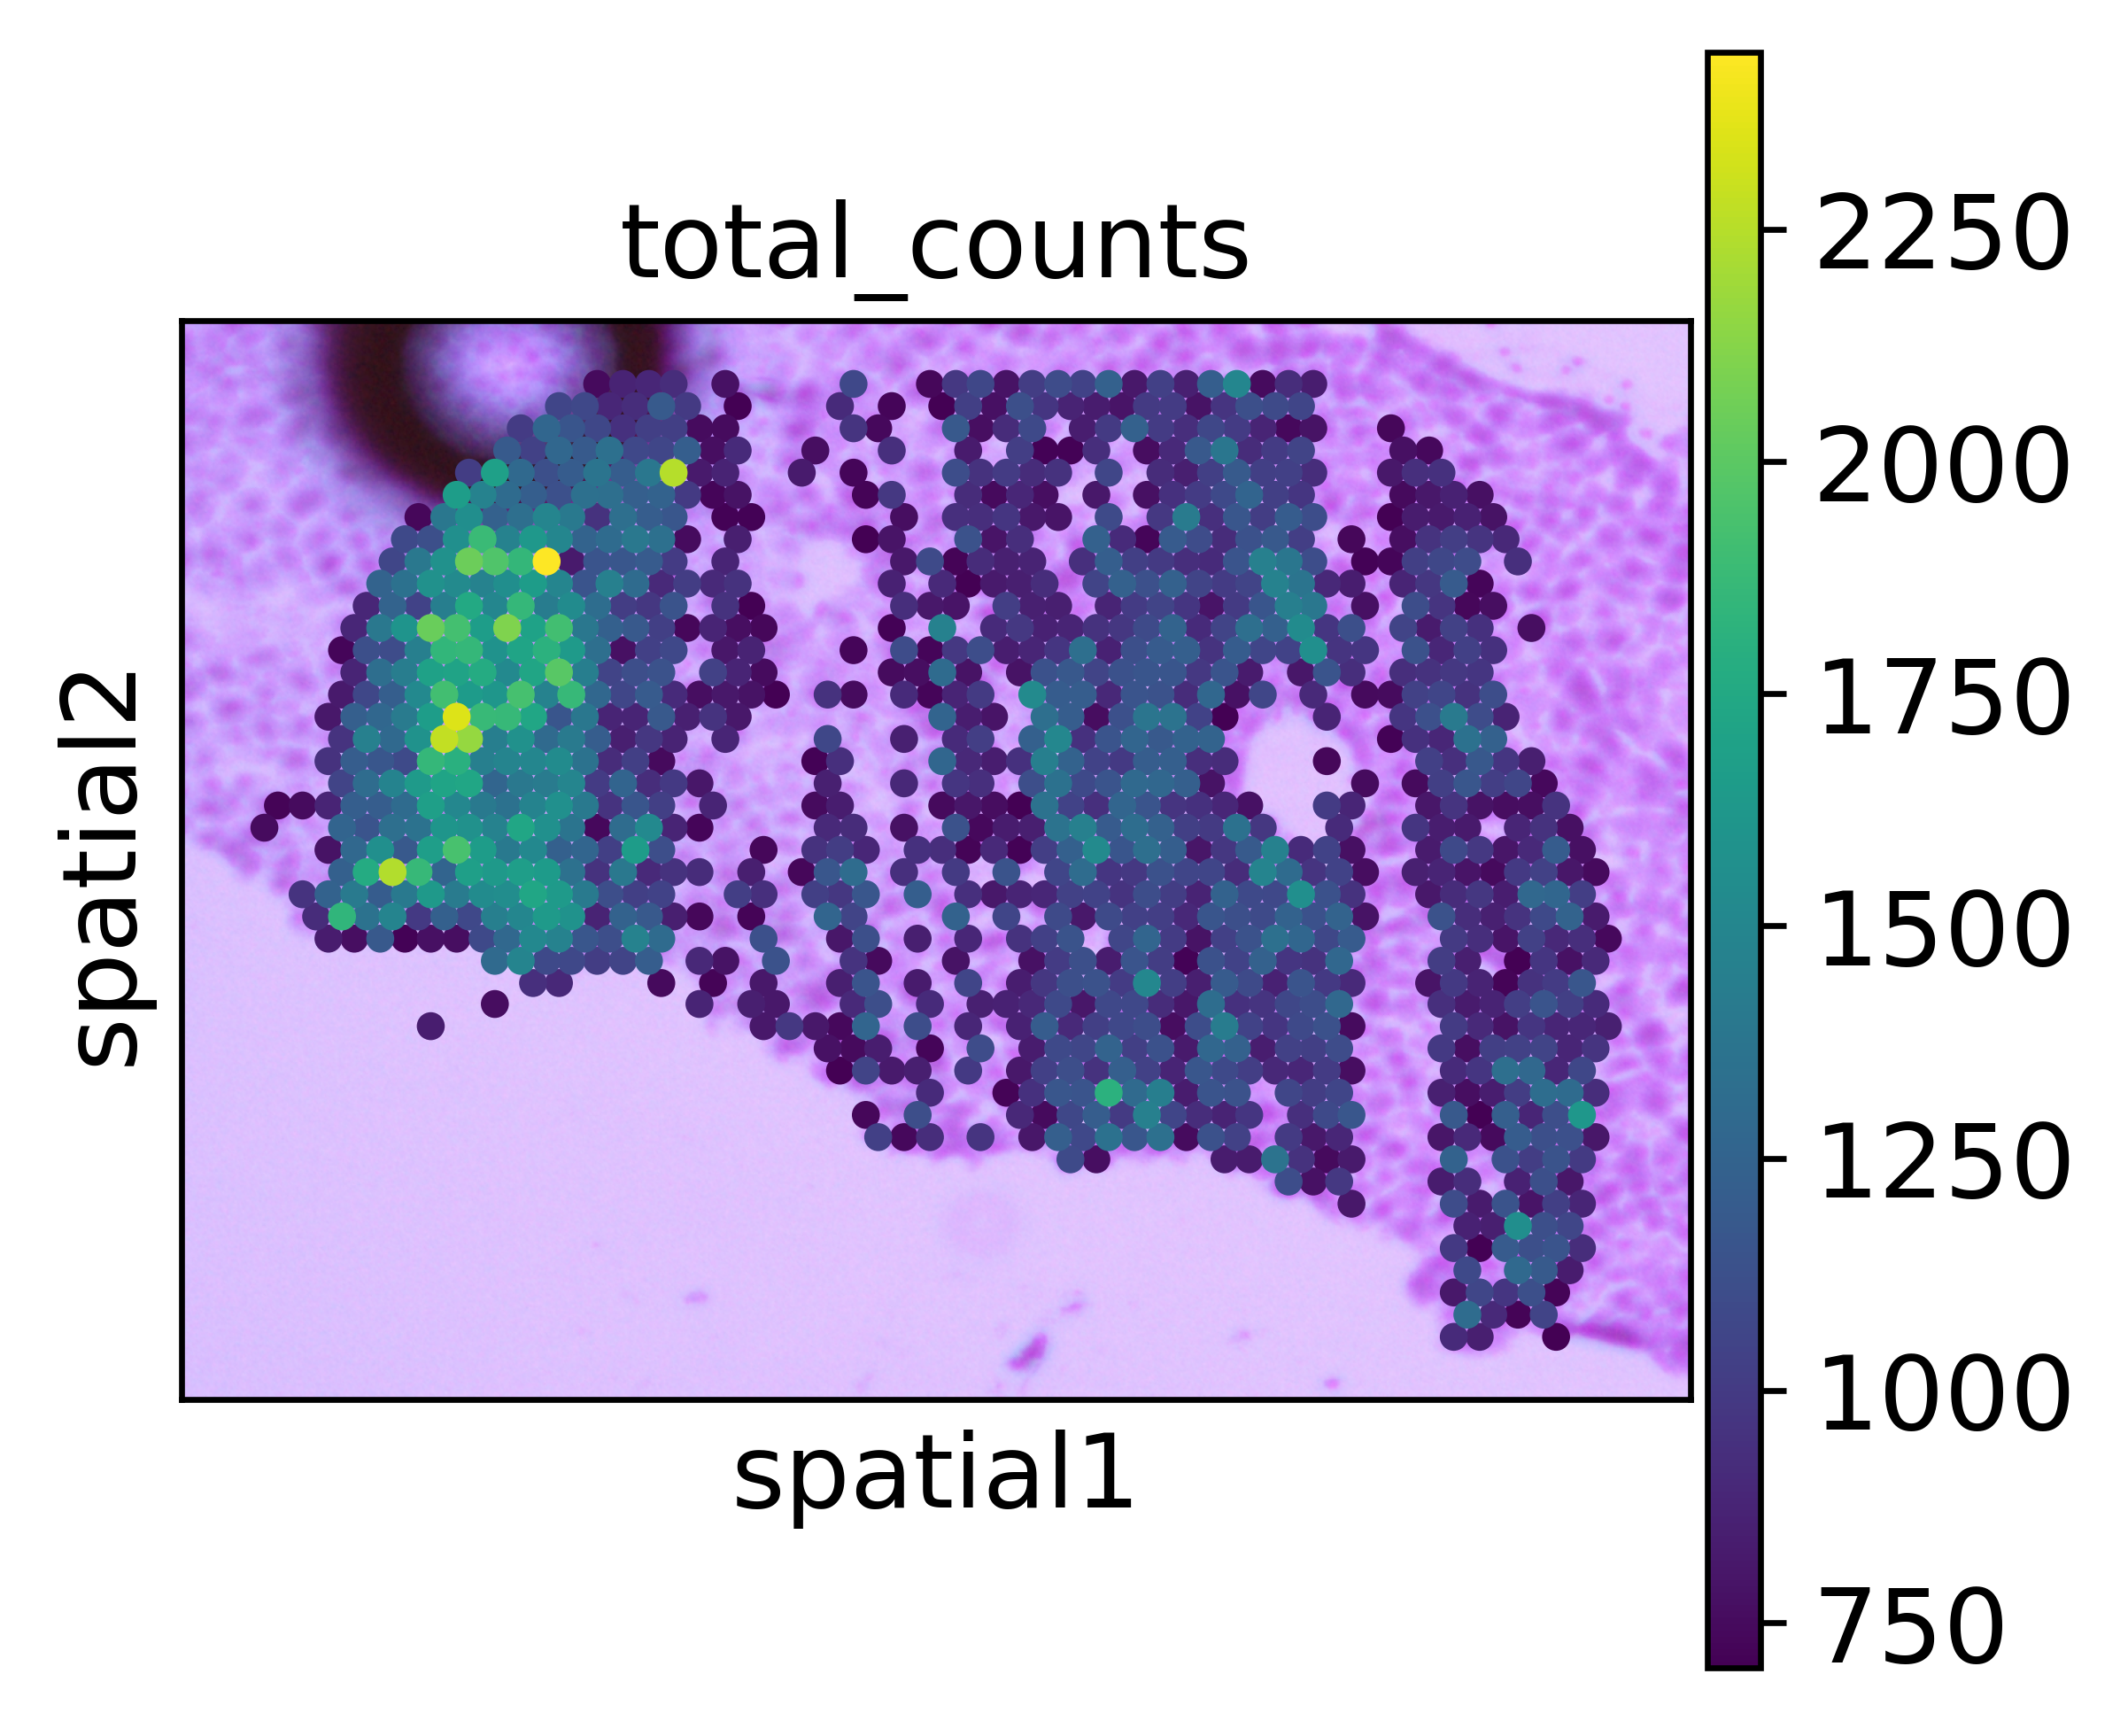

In [12]:
sc.pl.spatial(adata_seq_scope_attached[adata_seq_scope_attached.obs.total_counts > 700,],
              color='total_counts')